In [1]:
# Imports

import binascii
import time
import os
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange
from __future__ import print_function

import chipwhisperer as cw
from chipwhisperer.tests.tools_for_tests import FIRMWARE_DIR
from chipwhisperer.capture.api.programmers import XMEGAProgrammer

In [2]:
# Notebook settings
%matplotlib notebook

In [3]:
scope = cw.scope()
target = cw.target(scope)

In [4]:
# setup scope parameters
scope.gain.gain = 45
scope.adc.samples = 24000
scope.adc.offset = 0
scope.adc.basic_mode = "rising_edge"
scope.clock.clkgen_freq = 7370000
scope.clock.adc_src = "clkgen_x4"
scope.trigger.triggers = "tio4"
scope.io.tio1 = "serial_rx"
scope.io.tio2 = "serial_tx"
scope.io.hs2 = "clkgen"

In [5]:
firmware_dir = os.path.abspath(os.path.join(FIRMWARE_DIR, 'simpleserial-rsa-crt'))
hex_file = os.path.join(firmware_dir, r'simpleserial-rsa-crt-CW303.hex')
programmer = XMEGAProgrammer()
programmer.scope = scope
programmer._logging = None
programmer.find()
programmer.erase()
programmer.program(hex_file, memtype="flash", verify=True)
programmer.close()

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 13167 bytes


In [6]:
def getone(txi,key):
    target.init()
    target.loadEncryptionKey(key)
    target.loadInput(txi)
    scope.arm()
    target.go()
    timeout = 50
    while target.isDone() is False and timeout > 0:
        timeout -= 1
        time.sleep(0.01)
    try:
        ret = scope.capture()
        if ret:
            print('Timeout happened during acquisition')
    except IOError as e:
        print('IOError: %s' % str(e))
    txo = target.readOutput()
    trc = scope.getLastTrace()
    txo = "".join(['{:02x}'.format(i) for i in txo])
    return (txo,trc)
def plot(x):
    plt.figure()
    for i in x:
        plt.plot(i)
    plt.show()
def setup(eoff,rep,off,wid):
    scope.gain.gain          = 45
    scope.gain.mode          = 'low'
    scope.adc.samples        = 24000
    scope.adc.offset         = 0
    scope.adc.basic_mode     = "rising_edge"
    scope.adc.timeout        = 5
    scope.clock.clkgen_freq  = 7370000
    scope.clock.adc_src      = "clkgen_x4"
    scope.trigger.triggers   = "tio4"
    scope.io.tio1            = "serial_rx"
    scope.io.tio2            = "serial_tx"
    scope.glitch.clk_src     = 'clkgen'
    scope.glitch.width_fine  = 0
    scope.glitch.offset_fine = 0
    scope.glitch.trigger_src = 'ext_single'
    scope.glitch.arm_timing  = 'before_scope'
    scope.glitch.output      = 'clock_xor'
    scope.glitch.ext_offset  = eoff
    scope.glitch.repeat      = rep
    scope.glitch.offset      = off
    scope.glitch.width       = wid
    scope.io.hs2             = "glitch"

In [7]:
setup(0,1,1,1)

In [8]:
key = '{:032x}'.format(random.getrandbits(128))
txi = '{:032x}'.format(random.getrandbits(128))

fd000000000000000000000000000000


<IPython.core.display.Javascript object>


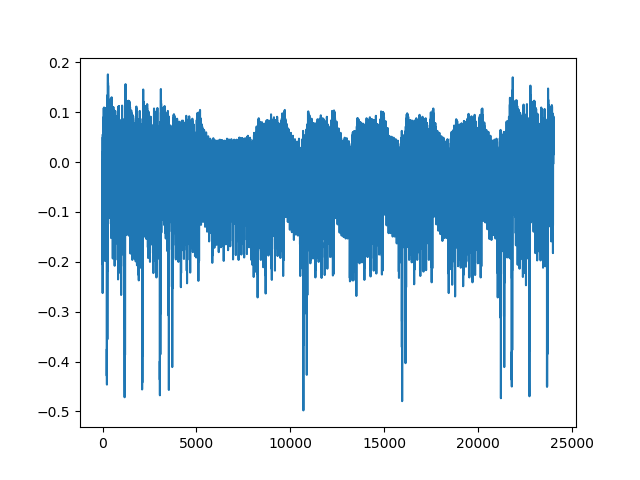

In [9]:
(txo,trc) = getone(key,txi)
print(txo)
plot((trc,))

In [10]:
print('txi:',txi)
print('key:',key)
print('txo:',txo)

txi: 97b968d3d4a0864d7d6dc07ece2b1856
key: 6818c8790293793f3642dfd557292ed6
txo: fd000000000000000000000000000000


In [11]:
setup(0,1,-3,5.5)
(txo,trc) = getone(key,txi)
print(txo)

a9ffffffffffffff0000000000000000


In [12]:
for i in range(10):
    setup(i,1,-3,6)
    (txo,trc) = getone(key,txi)
    print(txo)


fd000000000000000000000000000000
a9ffffffffffffff0000000000000000
41010000000000000000000000000000
fd000000000000000000000000000000
a9ffffffffffffff0000000000000000
a9ffffffffffffff0000000000000000
fd000000000000000000000000000000
fd000000000000000000000000000000
a9ffffffffffffff0000000000000000
a9ffffffffffffff0000000000000000


In [19]:
# cleanup the connection to the target and scope
scope.dis()
target.dis()